In [10]:
import pandas as pd

df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True) #pd.read_csv('qa_data.csv')

## Data Preprocessing: Lemmatization, Emoji removal, URL removal

In [11]:
# Data preprocessing

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# don't use stop words.

# init lemmatizer
lemmatizer = WordNetLemmatizer()
# Regular expression pattern for matching URLs
url_pattern = r'http\S+|www\S+|https\S+'

def clean_text(text):
    # Lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    # Remove all characters outside the ASCII range, including emojis and Hindi characters.
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove URLs from text
    text = re.sub(url_pattern, '', text, flags=re.MULTILINE)

    return text

df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)



In [5]:
df.head()

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isnt it awful? You would swear that there wasn...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song ha the lyric ""someone left the cake ...",MacArthur's Park
3,I am the owner of an adult website called Can...,Don't let apps that are liers put add on your ...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mention an ...


In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Train the model

In [7]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Split the dataset into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)

datasets = DatasetDict({
    'train': train_data,
    'validation': val_data
})

# Load pre-trained DistilGPT2 model and tokenizer
model_name = "distilgpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Add a padding token
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

# Define a function to tokenize the dataset
def tokenize_function(examples):
    questions = examples['question']
    answers = examples['answer']
    inputs = [f"Question: {q} Answer: {a}" for q, a in zip(questions, answers)]
    model_inputs = tokenizer(inputs, padding="max_length", truncation=True, max_length=1024)
    model_inputs["labels"] = model_inputs["input_ids"].copy()
    return model_inputs

# Tokenize the dataset
tokenized_datasets = datasets.map(tokenize_function, batched=True)

# Prepare the dataset for PyTorch
def format_dataset(tokenized_dataset):
    return tokenized_dataset.with_format("torch")

train_dataset = format_dataset(tokenized_datasets['train'])
val_dataset = format_dataset(tokenized_datasets['validation'])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",                 # Output directory
    evaluation_strategy="epoch",            # Evaluation strategy
    per_device_train_batch_size=2,          # Batch size for training
    per_device_eval_batch_size=2,           # Batch size for evaluation
    num_train_epochs=2,                     # Number of training epochs
    weight_decay=0.01,                      # Weight decay
    logging_dir="./logs",                   # Directory for logs
    save_steps=1000,                         # Save checkpoints every 1000 steps
    save_total_limit=2,                     # Keep only the last 3 checkpoints
    #fp16=True,                              # Mixed precision training (requires CUDA) (dont use, worsens signific.)
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained("fine-tuned-distilgpt2")
tokenizer.save_pretrained("fine-tuned-distilgpt2")

print("Training complete. Model and tokenizer saved.")


C:\Users\vaibh\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 11281/11281 [00:41<00:00, 274.90 examples/s]
C:\Users\vaibh\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/45122 [00:00<?, ?it/s]C:\Users\vaibh\AppData\Roaming\Python\Python312\site-packages\transformers\models\gpt2\modeling_gpt2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_atten

{'loss': 0.7638, 'grad_norm': 0.9886317253112793, 'learning_rate': 4.9445946544922654e-05, 'epoch': 0.02}


  2%|▏         | 1000/45122 [15:10<11:13:24,  1.09it/s]

{'loss': 0.6808, 'grad_norm': 0.6098201274871826, 'learning_rate': 4.8891893089845306e-05, 'epoch': 0.04}


  3%|▎         | 1500/45122 [22:51<11:05:16,  1.09it/s]

{'loss': 0.7298, 'grad_norm': 0.8305000066757202, 'learning_rate': 4.8337839634767964e-05, 'epoch': 0.07}


  4%|▍         | 2000/45122 [30:29<10:57:19,  1.09it/s]

{'loss': 0.733, 'grad_norm': 0.8294147849082947, 'learning_rate': 4.778378617969062e-05, 'epoch': 0.09}


  6%|▌         | 2500/45122 [38:07<10:45:04,  1.10it/s]

{'loss': 0.7085, 'grad_norm': 0.552254319190979, 'learning_rate': 4.7229732724613275e-05, 'epoch': 0.11}


  7%|▋         | 3000/45122 [45:43<10:41:20,  1.09it/s]

{'loss': 0.6607, 'grad_norm': 0.3225180506706238, 'learning_rate': 4.6675679269535926e-05, 'epoch': 0.13}


  8%|▊         | 3500/45122 [53:23<10:34:57,  1.09it/s]

{'loss': 0.7057, 'grad_norm': 0.5419062376022339, 'learning_rate': 4.612162581445858e-05, 'epoch': 0.16}


  9%|▉         | 4000/45122 [1:01:01<10:29:16,  1.09it/s]

{'loss': 0.6318, 'grad_norm': 0.6687925457954407, 'learning_rate': 4.556757235938123e-05, 'epoch': 0.18}


 10%|▉         | 4500/45122 [1:08:43<10:21:56,  1.09it/s]

{'loss': 0.7053, 'grad_norm': 0.37513330578804016, 'learning_rate': 4.501351890430389e-05, 'epoch': 0.2}


 11%|█         | 5000/45122 [1:18:30<15:30:51,  1.39s/it]

{'loss': 0.7565, 'grad_norm': 1.216505527496338, 'learning_rate': 4.445946544922655e-05, 'epoch': 0.22}


 12%|█▏        | 5500/45122 [1:30:06<15:13:24,  1.38s/it]

{'loss': 0.6929, 'grad_norm': 0.3866729736328125, 'learning_rate': 4.39054119941492e-05, 'epoch': 0.24}


 13%|█▎        | 6000/45122 [1:41:46<15:14:42,  1.40s/it]

{'loss': 0.648, 'grad_norm': 0.6865020394325256, 'learning_rate': 4.335135853907185e-05, 'epoch': 0.27}


 14%|█▍        | 6500/45122 [1:53:31<14:57:43,  1.39s/it]

{'loss': 0.7005, 'grad_norm': 0.44256818294525146, 'learning_rate': 4.27973050839945e-05, 'epoch': 0.29}


 16%|█▌        | 7000/45122 [2:05:07<14:42:01,  1.39s/it]

{'loss': 0.6999, 'grad_norm': 0.5261073112487793, 'learning_rate': 4.224325162891716e-05, 'epoch': 0.31}


 17%|█▋        | 7500/45122 [2:16:46<14:30:33,  1.39s/it]

{'loss': 0.6397, 'grad_norm': 0.4875703752040863, 'learning_rate': 4.168919817383982e-05, 'epoch': 0.33}


 18%|█▊        | 8000/45122 [2:28:22<14:24:23,  1.40s/it]

{'loss': 0.6917, 'grad_norm': 0.5085593461990356, 'learning_rate': 4.113514471876247e-05, 'epoch': 0.35}


 19%|█▉        | 8500/45122 [2:40:02<14:11:32,  1.40s/it]

{'loss': 0.6579, 'grad_norm': 0.5818943381309509, 'learning_rate': 4.058109126368512e-05, 'epoch': 0.38}


 20%|█▉        | 9000/45122 [2:51:38<13:57:45,  1.39s/it]

{'loss': 0.6339, 'grad_norm': 0.8916680216789246, 'learning_rate': 4.0027037808607775e-05, 'epoch': 0.4}


 21%|██        | 9500/45122 [3:03:19<13:48:24,  1.40s/it]

{'loss': 0.6978, 'grad_norm': 0.5580962896347046, 'learning_rate': 3.9472984353530426e-05, 'epoch': 0.42}


 22%|██▏       | 10000/45122 [3:14:54<13:38:01,  1.40s/it]

{'loss': 0.6142, 'grad_norm': 0.602072536945343, 'learning_rate': 3.8918930898453085e-05, 'epoch': 0.44}


 23%|██▎       | 10500/45122 [3:26:32<13:26:15,  1.40s/it]

{'loss': 0.6451, 'grad_norm': 0.36748766899108887, 'learning_rate': 3.8364877443375743e-05, 'epoch': 0.47}


 24%|██▍       | 11000/45122 [3:38:10<13:07:34,  1.38s/it]

{'loss': 0.6424, 'grad_norm': 0.45002037286758423, 'learning_rate': 3.7810823988298395e-05, 'epoch': 0.49}


 25%|██▌       | 11500/45122 [3:49:49<13:01:16,  1.39s/it]

{'loss': 0.6538, 'grad_norm': 0.6726819276809692, 'learning_rate': 3.725677053322105e-05, 'epoch': 0.51}


 27%|██▋       | 12000/45122 [4:01:27<12:46:24,  1.39s/it]

{'loss': 0.6445, 'grad_norm': 0.40074121952056885, 'learning_rate': 3.67027170781437e-05, 'epoch': 0.53}


 28%|██▊       | 12500/45122 [4:13:06<12:33:20,  1.39s/it]

{'loss': 0.6308, 'grad_norm': 1.0532300472259521, 'learning_rate': 3.614866362306635e-05, 'epoch': 0.55}


 29%|██▉       | 13000/45122 [4:24:40<12:19:54,  1.38s/it]

{'loss': 0.6175, 'grad_norm': 0.8211129903793335, 'learning_rate': 3.559461016798901e-05, 'epoch': 0.58}


 30%|██▉       | 13500/45122 [4:36:18<12:14:30,  1.39s/it]

{'loss': 0.645, 'grad_norm': 0.3959653675556183, 'learning_rate': 3.504055671291167e-05, 'epoch': 0.6}


 31%|███       | 14000/45122 [4:47:56<12:04:59,  1.40s/it]

{'loss': 0.6238, 'grad_norm': 0.41259682178497314, 'learning_rate': 3.448650325783432e-05, 'epoch': 0.62}


 32%|███▏      | 14500/45122 [4:59:36<11:51:15,  1.39s/it]

{'loss': 0.6356, 'grad_norm': 0.4326263666152954, 'learning_rate': 3.393244980275697e-05, 'epoch': 0.64}


 33%|███▎      | 15000/45122 [5:11:13<11:44:03,  1.40s/it]

{'loss': 0.5968, 'grad_norm': 1.1558935642242432, 'learning_rate': 3.337839634767962e-05, 'epoch': 0.66}


 34%|███▍      | 15500/45122 [5:22:52<11:27:52,  1.39s/it]

{'loss': 0.6748, 'grad_norm': 0.44999411702156067, 'learning_rate': 3.2824342892602275e-05, 'epoch': 0.69}


 35%|███▌      | 16000/45122 [5:34:29<11:19:23,  1.40s/it]

{'loss': 0.6509, 'grad_norm': 1.0221956968307495, 'learning_rate': 3.227028943752493e-05, 'epoch': 0.71}


 37%|███▋      | 16500/45122 [5:46:08<11:05:19,  1.39s/it]

{'loss': 0.6326, 'grad_norm': 0.6162330508232117, 'learning_rate': 3.171623598244759e-05, 'epoch': 0.73}


 38%|███▊      | 17000/45122 [5:57:45<10:54:55,  1.40s/it]

{'loss': 0.5865, 'grad_norm': 0.2986830770969391, 'learning_rate': 3.1162182527370243e-05, 'epoch': 0.75}


 39%|███▉      | 17500/45122 [6:09:24<10:41:44,  1.39s/it]

{'loss': 0.689, 'grad_norm': 0.3280164897441864, 'learning_rate': 3.0608129072292895e-05, 'epoch': 0.78}


 40%|███▉      | 18000/45122 [6:20:59<10:31:20,  1.40s/it]

{'loss': 0.6429, 'grad_norm': 0.6091033816337585, 'learning_rate': 3.005407561721555e-05, 'epoch': 0.8}


 41%|████      | 18500/45122 [6:32:42<10:18:27,  1.39s/it]

{'loss': 0.6016, 'grad_norm': 0.5544474720954895, 'learning_rate': 2.9500022162138202e-05, 'epoch': 0.82}


 42%|████▏     | 19000/45122 [6:44:17<10:02:40,  1.38s/it]

{'loss': 0.6499, 'grad_norm': 0.27999749779701233, 'learning_rate': 2.894596870706086e-05, 'epoch': 0.84}


 43%|████▎     | 19500/45122 [6:55:51<9:48:51,  1.38s/it] 

{'loss': 0.6415, 'grad_norm': 0.3920709192752838, 'learning_rate': 2.8391915251983516e-05, 'epoch': 0.86}


 44%|████▍     | 20000/45122 [7:07:25<9:37:56,  1.38s/it] 

{'loss': 0.6397, 'grad_norm': 0.6490933299064636, 'learning_rate': 2.7837861796906168e-05, 'epoch': 0.89}


 45%|████▌     | 20500/45122 [7:18:59<9:27:00,  1.38s/it] 

{'loss': 0.626, 'grad_norm': 0.48027563095092773, 'learning_rate': 2.728380834182882e-05, 'epoch': 0.91}


 47%|████▋     | 21000/45122 [7:30:31<9:14:29,  1.38s/it]

{'loss': 0.6231, 'grad_norm': 0.3302929699420929, 'learning_rate': 2.6729754886751474e-05, 'epoch': 0.93}


 48%|████▊     | 21500/45122 [7:42:06<9:06:33,  1.39s/it] 

{'loss': 0.6249, 'grad_norm': 0.8825355768203735, 'learning_rate': 2.6175701431674126e-05, 'epoch': 0.95}


 49%|████▉     | 22000/45122 [7:53:39<8:52:48,  1.38s/it]

{'loss': 0.6293, 'grad_norm': 0.4261011481285095, 'learning_rate': 2.5621647976596785e-05, 'epoch': 0.98}


 50%|████▉     | 22500/45122 [8:05:15<8:41:46,  1.38s/it] 

{'loss': 0.6383, 'grad_norm': 0.45963558554649353, 'learning_rate': 2.506759452151944e-05, 'epoch': 1.0}


                                                         
 50%|█████     | 22561/45122 [8:43:05<7:10:08,  1.14s/it]

{'eval_loss': 0.614281415939331, 'eval_runtime': 2186.6179, 'eval_samples_per_second': 5.159, 'eval_steps_per_second': 2.58, 'epoch': 1.0}


 51%|█████     | 23000/45122 [8:53:13<8:29:05,  1.38s/it]    

{'loss': 0.6257, 'grad_norm': 0.6665874719619751, 'learning_rate': 2.451354106644209e-05, 'epoch': 1.02}


 52%|█████▏    | 23500/45122 [9:04:46<8:18:14,  1.38s/it] 

{'loss': 0.6021, 'grad_norm': 0.646066427230835, 'learning_rate': 2.3959487611364743e-05, 'epoch': 1.04}


 53%|█████▎    | 24000/45122 [9:16:16<8:04:27,  1.38s/it]

{'loss': 0.5872, 'grad_norm': 0.5015208125114441, 'learning_rate': 2.3405434156287402e-05, 'epoch': 1.06}


 54%|█████▍    | 24500/45122 [9:27:49<7:55:01,  1.38s/it] 

{'loss': 0.5952, 'grad_norm': 0.43640339374542236, 'learning_rate': 2.2851380701210054e-05, 'epoch': 1.09}


 55%|█████▌    | 25000/45122 [9:39:20<7:43:02,  1.38s/it]

{'loss': 0.5892, 'grad_norm': 0.29593485593795776, 'learning_rate': 2.2297327246132705e-05, 'epoch': 1.11}


 57%|█████▋    | 25500/45122 [9:50:58<7:35:12,  1.39s/it] 

{'loss': 0.6239, 'grad_norm': 0.740753710269928, 'learning_rate': 2.1743273791055364e-05, 'epoch': 1.13}


 58%|█████▊    | 26000/45122 [10:02:31<7:20:27,  1.38s/it]

{'loss': 0.6141, 'grad_norm': 0.6877084970474243, 'learning_rate': 2.1189220335978016e-05, 'epoch': 1.15}


 59%|█████▊    | 26500/45122 [10:14:06<7:08:04,  1.38s/it] 

{'loss': 0.6316, 'grad_norm': 1.1326110363006592, 'learning_rate': 2.063516688090067e-05, 'epoch': 1.17}


 60%|█████▉    | 27000/45122 [10:25:40<7:01:31,  1.40s/it]

{'loss': 0.6063, 'grad_norm': 0.6317457556724548, 'learning_rate': 2.0081113425823326e-05, 'epoch': 1.2}


 61%|██████    | 27500/45122 [10:37:17<6:45:56,  1.38s/it] 

{'loss': 0.5648, 'grad_norm': 0.5186416506767273, 'learning_rate': 1.9527059970745978e-05, 'epoch': 1.22}


 62%|██████▏   | 28000/45122 [10:48:53<6:37:22,  1.39s/it]

{'loss': 0.543, 'grad_norm': 0.5695907473564148, 'learning_rate': 1.8973006515668633e-05, 'epoch': 1.24}


 63%|██████▎   | 28500/45122 [11:00:35<6:30:22,  1.41s/it]

{'loss': 0.5897, 'grad_norm': 0.549483597278595, 'learning_rate': 1.8418953060591288e-05, 'epoch': 1.26}


 64%|██████▍   | 29000/45122 [11:12:12<6:14:32,  1.39s/it]

{'loss': 0.5991, 'grad_norm': 0.9870848655700684, 'learning_rate': 1.786489960551394e-05, 'epoch': 1.29}


 65%|██████▌   | 29500/45122 [11:47:09<24:46:25,  5.71s/it]

{'loss': 0.5766, 'grad_norm': 0.4350868761539459, 'learning_rate': 1.7310846150436595e-05, 'epoch': 1.31}


 66%|██████▋   | 30000/45122 [12:11:00<3:48:19,  1.10it/s]  

{'loss': 0.6181, 'grad_norm': 0.43859076499938965, 'learning_rate': 1.675679269535925e-05, 'epoch': 1.33}


 68%|██████▊   | 30500/45122 [12:18:39<3:43:07,  1.09it/s]

{'loss': 0.5694, 'grad_norm': 0.546805739402771, 'learning_rate': 1.6202739240281902e-05, 'epoch': 1.35}


 69%|██████▊   | 31000/45122 [12:26:19<3:36:16,  1.09it/s]

{'loss': 0.6138, 'grad_norm': 0.3848252296447754, 'learning_rate': 1.5648685785204557e-05, 'epoch': 1.37}


 70%|██████▉   | 31500/45122 [12:34:24<3:28:07,  1.09it/s] 

{'loss': 0.5878, 'grad_norm': 0.6858037710189819, 'learning_rate': 1.5094632330127212e-05, 'epoch': 1.4}


 71%|███████   | 32000/45122 [12:42:03<3:20:54,  1.09it/s]

{'loss': 0.6399, 'grad_norm': 0.3700045943260193, 'learning_rate': 1.4540578875049866e-05, 'epoch': 1.42}


 72%|███████▏  | 32500/45122 [12:49:44<3:12:41,  1.09it/s]

{'loss': 0.6179, 'grad_norm': 1.473092794418335, 'learning_rate': 1.398652541997252e-05, 'epoch': 1.44}


 73%|███████▎  | 33000/45122 [12:57:23<3:05:10,  1.09it/s]

{'loss': 0.5778, 'grad_norm': 0.43072566390037537, 'learning_rate': 1.3432471964895174e-05, 'epoch': 1.46}


 74%|███████▍  | 33500/45122 [13:05:04<2:57:45,  1.09it/s]

{'loss': 0.5971, 'grad_norm': 0.37963035702705383, 'learning_rate': 1.2878418509817828e-05, 'epoch': 1.48}


 75%|███████▌  | 34000/45122 [13:12:44<2:50:07,  1.09it/s]

{'loss': 0.6216, 'grad_norm': 0.460654616355896, 'learning_rate': 1.2324365054740481e-05, 'epoch': 1.51}


 76%|███████▋  | 34500/45122 [13:20:25<2:42:58,  1.09it/s]

{'loss': 0.6222, 'grad_norm': 0.42659834027290344, 'learning_rate': 1.1770311599663136e-05, 'epoch': 1.53}


 78%|███████▊  | 35000/45122 [13:28:05<2:35:41,  1.08it/s]

{'loss': 0.609, 'grad_norm': 0.5151253938674927, 'learning_rate': 1.121625814458579e-05, 'epoch': 1.55}


 79%|███████▊  | 35500/45122 [13:35:49<2:27:30,  1.09it/s]

{'loss': 0.5982, 'grad_norm': 0.7486207485198975, 'learning_rate': 1.0662204689508445e-05, 'epoch': 1.57}


 80%|███████▉  | 36000/45122 [13:43:28<2:19:11,  1.09it/s]

{'loss': 0.6466, 'grad_norm': 0.6907454133033752, 'learning_rate': 1.0108151234431098e-05, 'epoch': 1.6}


 81%|████████  | 36500/45122 [13:51:09<2:11:11,  1.10it/s]

{'loss': 0.621, 'grad_norm': 0.5833781361579895, 'learning_rate': 9.554097779353753e-06, 'epoch': 1.62}


 82%|████████▏ | 37000/45122 [13:58:46<2:03:51,  1.09it/s]

{'loss': 0.615, 'grad_norm': 0.30791088938713074, 'learning_rate': 9.000044324276407e-06, 'epoch': 1.64}


 83%|████████▎ | 37500/45122 [14:06:27<1:56:20,  1.09it/s]

{'loss': 0.5868, 'grad_norm': 0.45508521795272827, 'learning_rate': 8.44599086919906e-06, 'epoch': 1.66}


 84%|████████▍ | 38000/45122 [14:14:04<1:48:37,  1.09it/s]

{'loss': 0.6381, 'grad_norm': 0.2956258952617645, 'learning_rate': 7.891937414121715e-06, 'epoch': 1.68}


 85%|████████▌ | 38500/45122 [14:21:45<1:40:56,  1.09it/s]

{'loss': 0.6482, 'grad_norm': 1.2814077138900757, 'learning_rate': 7.337883959044369e-06, 'epoch': 1.71}


 86%|████████▋ | 39000/45122 [14:29:24<1:32:58,  1.10it/s]

{'loss': 0.5897, 'grad_norm': 1.0097264051437378, 'learning_rate': 6.783830503967023e-06, 'epoch': 1.73}


 88%|████████▊ | 39500/45122 [14:37:05<1:25:53,  1.09it/s]

{'loss': 0.6163, 'grad_norm': 0.6236655116081238, 'learning_rate': 6.229777048889677e-06, 'epoch': 1.75}


 89%|████████▊ | 40000/45122 [14:44:43<1:18:00,  1.09it/s]

{'loss': 0.6234, 'grad_norm': 0.6921308636665344, 'learning_rate': 5.675723593812332e-06, 'epoch': 1.77}


 90%|████████▉ | 40500/45122 [14:52:25<1:10:35,  1.09it/s]

{'loss': 0.6198, 'grad_norm': 0.6010262966156006, 'learning_rate': 5.121670138734985e-06, 'epoch': 1.8}


 91%|█████████ | 41000/45122 [15:00:04<1:03:13,  1.09it/s]

{'loss': 0.5898, 'grad_norm': 0.5912821292877197, 'learning_rate': 4.5676166836576395e-06, 'epoch': 1.82}


 92%|█████████▏| 41500/45122 [15:07:47<55:10,  1.09it/s]  

{'loss': 0.6332, 'grad_norm': 0.40001723170280457, 'learning_rate': 4.013563228580294e-06, 'epoch': 1.84}


 93%|█████████▎| 42000/45122 [15:15:26<47:50,  1.09it/s]

{'loss': 0.6062, 'grad_norm': 0.4524606466293335, 'learning_rate': 3.4595097735029473e-06, 'epoch': 1.86}


 94%|█████████▍| 42500/45122 [15:23:10<40:15,  1.09it/s]  

{'loss': 0.6323, 'grad_norm': 0.4200754165649414, 'learning_rate': 2.905456318425602e-06, 'epoch': 1.88}


 95%|█████████▌| 43000/45122 [15:30:51<32:41,  1.08it/s]

{'loss': 0.6129, 'grad_norm': 0.49949535727500916, 'learning_rate': 2.351402863348256e-06, 'epoch': 1.91}


 96%|█████████▋| 43500/45122 [15:38:34<24:56,  1.08it/s]

{'loss': 0.5975, 'grad_norm': 0.48726463317871094, 'learning_rate': 1.79734940827091e-06, 'epoch': 1.93}


 98%|█████████▊| 44000/45122 [15:46:15<17:13,  1.09it/s]

{'loss': 0.5557, 'grad_norm': 0.4814179241657257, 'learning_rate': 1.2432959531935642e-06, 'epoch': 1.95}


 99%|█████████▊| 44500/45122 [15:53:58<09:34,  1.08it/s]

{'loss': 0.6249, 'grad_norm': 0.6679644584655762, 'learning_rate': 6.892424981162182e-07, 'epoch': 1.97}


100%|█████████▉| 45000/45122 [16:01:38<01:51,  1.09it/s]

{'loss': 0.6093, 'grad_norm': 1.1902377605438232, 'learning_rate': 1.351890430388724e-07, 'epoch': 1.99}


                                                        
100%|██████████| 45122/45122 [16:28:21<00:00,  1.31s/it]


{'eval_loss': 0.6029723286628723, 'eval_runtime': 1485.5916, 'eval_samples_per_second': 7.594, 'eval_steps_per_second': 3.797, 'epoch': 2.0}
{'train_runtime': 59301.8611, 'train_samples_per_second': 1.522, 'train_steps_per_second': 0.761, 'train_loss': 0.6326761483712842, 'epoch': 2.0}
Training complete. Model and tokenizer saved.


## Evaluation of model: Compute the ROGUE score

In [38]:
# Load the trained model
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("fine-tuned-distilgpt2")

# Load the model
model = GPT2LMHeadModel.from_pretrained("fine-tuned-distilgpt2").to(device)

# Initialize the scorer
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

In [54]:

# Example references and hypotheses
#references = ["The quick brown fox jumps over the lazy dog."]
#hypotheses = ["The fast brown fox leaps over the lazy dog."]

# Compute scores
#scores = scorer.score(references[0], hypotheses[0])

# Output the scores
#print(scores)

avg_rouge1_precision = 0
avg_rouge1_recall = 0
avg_rouge1_f = 0

avg_rouge2_precision = 0
avg_rouge2_recall = 0
avg_rouge2_f = 0

for index, row in val_df.iterrows():
    q = row['question']
    a = row['answer']
    if q == '' or a == '':
        continue
    #tokenize
    inputs = tokenizer(q, return_tensors="pt", padding=True, truncation=True).to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    # Generate the answer
    outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, pad_token_id = tokenizer.eos_token_id, max_length=1024, early_stopping=True, temperature=0.7,
                        repetition_penalty=1.11)
    # Decode the generated answer
    a_gen = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # compute the score
    score = scorer.score(a, a_gen)
    avg_rouge1_precision += score['rouge1'].precision
    avg_rouge1_recall += score['rouge1'].recall
    avg_rouge1_f += score['rouge1'].fmeasure
    avg_rouge2_precision += score['rouge2'].precision
    avg_rouge2_recall += score['rouge2'].recall
    avg_rouge2_f += score['rouge2'].fmeasure
    print(score)

avg_rouge1_precision /= len(val_df)
avg_rouge1_recall /= len(val_df)
avg_rouge1_f /= len(val_df)

avg_rouge2_precision/= len(val_df)
avg_rouge2_recall /= len(val_df)
avg_rouge2_f /= len(val_df)
print("\nROGUE statistics on Validation dataset:")
print("Rogue1 scores (order: precision, recall, f):", avg_rouge1_precision, avg_rouge1_recall, avg_rouge1_f)
print("Rogue2 scores (order: precision, recall, f):", avg_rouge2_precision, avg_rouge2_recall, avg_rouge2_f)

C:\Users\vaibh\AppData\Roaming\Python\Python312\site-packages\transformers\generation\configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\vaibh\AppData\Roaming\Python\Python312\site-packages\transformers\generation\configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


{'rouge1': Score(precision=0.6, recall=0.13953488372093023, fmeasure=0.22641509433962265), 'rouge2': Score(precision=0.21052631578947367, recall=0.047058823529411764, fmeasure=0.07692307692307691)}
{'rouge1': Score(precision=0.20202020202020202, recall=0.13245033112582782, fmeasure=0.16), 'rouge2': Score(precision=0.02040816326530612, recall=0.013333333333333334, fmeasure=0.016129032258064516)}
{'rouge1': Score(precision=0.007416563658838072, recall=0.3, fmeasure=0.014475271411338963), 'rouge2': Score(precision=0.0012376237623762376, recall=0.05263157894736842, fmeasure=0.0024183796856106408)}
{'rouge1': Score(precision=0.06521739130434782, recall=0.4, fmeasure=0.11214953271028037), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
{'rouge1': Score(precision=0.3333333333333333, recall=0.2909090909090909, fmeasure=0.31067961165048535), 'rouge2': Score(precision=0.10638297872340426, recall=0.09259259259259259, fmeasure=0.09900990099009901)}
{'rouge1': Score(precision=0.8787878787

KeyboardInterrupt: 

In [55]:
# Only applicable limited, this cell needs to be removed if all val set needs to be checked.
avg_rouge1_precision /= 197
avg_rouge1_recall /= 197
avg_rouge1_f /= 197

avg_rouge2_precision/= 197
avg_rouge2_recall /= 197
avg_rouge2_f /= 197
print("\nROGUE statistics on Validation dataset:")
print("Rogue1 scores (order: precision, recall, f):", avg_rouge1_precision, avg_rouge1_recall, avg_rouge1_f)
print("Rogue2 scores (order: precision, recall, f):", avg_rouge2_precision, avg_rouge2_recall, avg_rouge2_f)


ROGUE statistics on Validation dataset:
Rogue1 scores (order: precision, recall, f): 0.25964345338822853 0.21765670444083307 0.15738381536639987
Rogue2 scores (order: precision, recall, f): 0.05826736110733983 0.036458296397637924 0.029555665906071206


## Some questions asked to the model

In [86]:
question = "what industry need lead generation and marketing"

# Encode the input
inputs = tokenizer(question, return_tensors="pt", padding=True, truncation=True).to(device)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Generate the answer
outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, pad_token_id = tokenizer.eos_token_id, max_length=256, early_stopping=True, temperature=0.7,
                        repetition_penalty=1.11)
# Decode the generated answer
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Answer:", answer)

Answer: what industry need lead generation and marketing? Answer: Lead generation and marketing are two different field of business. Lead generation and marketing are two different fields, one is to connect with potential customer and build brand awareness. Lead generation and marketing are two different field that are both essential for business to grow and expand their reach. Here are some key point to consider: 1. Research and Optimize Your Website: Before starting your website, it's important to understand the content you're promoting. This will help you tailor your content to meet the need of your audience. 2. Create a Content Strategy: Develop a content strategy that outline your content strategy and how it will impact your business. This includes creating high-quality, engaging, and engaging content that resonates with your target audience. 3. Promote Your Products: Share your product or service to attract new customers. This can include product reviews, reviews, and other relev

In [11]:
question = "how to use a proxy"

# Encode the input
inputs = tokenizer(question, return_tensors="pt", padding=True, truncation=True).to(device)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Generate the answer
outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, pad_token_id = tokenizer.eos_token_id, max_length=256, early_stopping=True, temperature=0.7,
                        repetition_penalty=1.2)

# Decode the generated answer
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Answer:", answer)

Answer: how to use a proxy, and how can I use one? Answer: Proxy server are a type of web application that us the internet. They are used for various purposes, such as browsing, accessing websites, or accessing file on the Internet. Proxy server are used by various service provider to provide access to website and other data. They are used in various way to protect your privacy and security from unauthorized access. Some popular proxy server include Google Chrome, which provides a wide range of proxy server for various purposes. These proxy server allow user to browse the internet without any restriction or restrictions. However, some common practice involve using different proxies, such an IP address (IP), a well a setting up VPNs, which can be used to track and access website from anywhere. Additionally, these proxy server allow user to access website directly through their mobile devices, which can help them stay connected with others online.


In [17]:
question = "What are the must-have iPhone apps"

# Encode the input
inputs = tokenizer(question, return_tensors="pt", padding=True, truncation=True).to(device)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Generate the answer
outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, pad_token_id = tokenizer.eos_token_id, max_length=512, early_stopping=True, temperature=0.7,
                        repetition_penalty=1.19)

# Decode the generated answer
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Answer:", answer)

Answer: What are the must-have iPhone apps? Why? Answer: There are many must-have iPhone apps available, including Google Play Store and Apple Music. Here are some of the most popular and widely used apps for Android: 1) Apps for music streaming: Spotify, YouTube Video Player (iTunes), and Apple Music playlists can be a great way to listen to your favorite song or create a playlist that is more relevant than others. 2)(Music streaming app): Spotify offer a wide range in it genre such as classical rock/rock, electronica, and pop. It's important to note these apps are not intended solely on a specific device, and they may require additional processing and maintenance to ensure they are user-friendly and user-friendly. 3.) App Store: Apple Store provides a wide selection of apps for Android devices, including iWatch TV, iWatch Pro Max HD, and iMovie. These apps are designed specifically for Android devices, and are designed with the goal of providing a seamless experience for both users' 

In [47]:
question = "What is the color code for 52M ohm"

# Encode the input
inputs = tokenizer(question, return_tensors="pt", padding=True, truncation=True).to(device)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Generate the answer
outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, pad_token_id = tokenizer.eos_token_id, max_length=256, early_stopping=True, temperature=0.7,
                        repetition_penalty=1.3)
# Decode the generated answer
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Answer:", answer)

Answer: What is the color code for 52M ohm? Answer: I have a black and white laptop with a black screen.


## Attention Heatmap for feature importance

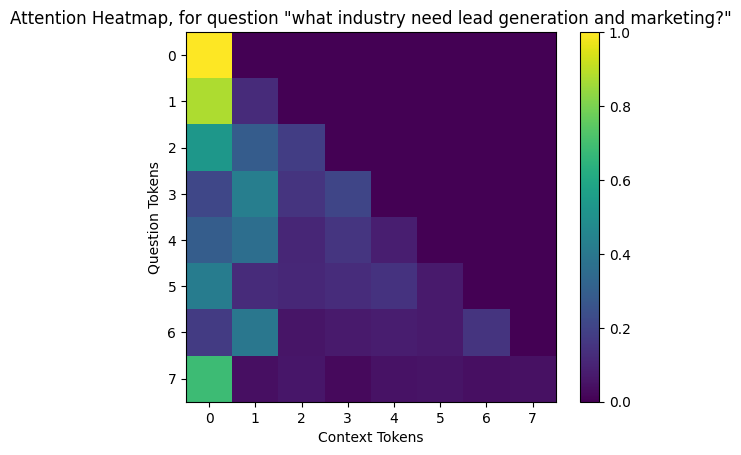

In [83]:
import matplotlib.pyplot as plt
# Example input
question = "what industry need lead generation and marketing?"

# Tokenize inputs
inputs = tokenizer(question, return_tensors='pt').to(device)

# Get model outputs
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

# Select a specific attention layer
attention_layer = attentions[0][0]  # First layer's attention

# Plot attention
plt.imshow(attention_layer[0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Attention Heatmap, \
for question "what industry need lead generation and marketing?"')
plt.xlabel('Context Tokens')
plt.ylabel('Question Tokens')
plt.show()